<a href="https://colab.research.google.com/github/JuanjoRestrepo/Qatar-2022/blob/main/WorldCup_Qatar2022_Predictor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
from string import ascii_uppercase as alphabet
import time
import numpy as np
import pickle

# **1. Recolección de Datos**

In [ ]:
#all_tables = pd.read_html('https://en.wikipedia.org/wiki/2022_FIFA_World_Cup')
all_tables = pd.read_html('https://web.archive.org/web/20221115040351/https://en.wikipedia.org/wiki/2022_FIFA_World_Cup')

## **1.1 Obteniendo los grupos**

#### Como son 8 grupos (A -> H) y en el link las tablas de estos están ordenados cada 7 posiciones (desde la 12) haremos lo siguiente para obtener la tabla de cada grupo:
- 11 -> 7*8 + 12 = 67

In [ ]:
all_tables[12]
all_tables[19]
all_tables[26]
all_tables[61]

,Pos,Teamvte,Pld,W,D,L,GF,GA,GD,Pts,Qualification
0,1,Portugal,0,0,0,0,0,0,0,0,Advance to knockout stage
1,2,Ghana,0,0,0,0,0,0,0,0,Advance to knockout stage
2,3,Uruguay,0,0,0,0,0,0,0,0,NaN
3,4,South Korea,0,0,0,0,0,0,0,0,NaN


Como vemos el último grupo (H) está en la posición 61, por lo cual haremos un recorrido hasta ese rango que calculamos anteriorment y haremos unas modificaciones al formato de la tabla original que nos presenta el dataset.

Reemplazaremos el nombre de la columna 'Teamvte' por solo 'Team' pero hay una excepción en el primer grupo (A) y es que tiene un formato de 'Team.mw' en su columna de equipos, por lo cual haremos lo siguiente

In [ ]:
all_tables[12].columns[1]

'Team.mw-parser-output .navbar{display:inline;font-size:88%;font-weight:normal}.mw-parser-output .navbar-collapse{float:left;text-align:left}.mw-parser-output .navbar-boxtext{word-spacing:0}.mw-parser-output .navbar ul{display:inline-block;white-space:nowrap;line-height:inherit}.mw-parser-output .navbar-brackets::before{margin-right:-0.125em;content:"[ "}.mw-parser-output .navbar-brackets::after{margin-left:-0.125em;content:" ]"}.mw-parser-output .navbar li{word-spacing:-0.125em}.mw-parser-output .navbar a>span,.mw-parser-output .navbar a>abbr{text-decoration:inherit}.mw-parser-output .navbar-mini abbr{font-variant:small-caps;border-bottom:none;text-decoration:none;cursor:inherit}.mw-parser-output .navbar-ct-full{font-size:114%;margin:0 7em}.mw-parser-output .navbar-ct-mini{font-size:114%;margin:0 4em}vte'

Asignamos el valor numerico de las tablas a su grupo correspondiente

In [ ]:
for letter, i in zip(alphabet, range(12, 68, 7)):
  print(letter, i)

A 12
B 19
C 26
D 33
E 40
F 47
G 54
H 61


In [ ]:
dict_tables = {}
for letter, i in zip(alphabet, range(12, 68, 7)):
  df = all_tables[i]
  df.rename(columns={df.columns[1]: 'Team'}, inplace=True)
  df.pop('Qualification')
  dict_tables[f'Group {letter}'] = df

In [ ]:
dict_tables.keys()

dict_keys(['Group A', 'Group B', 'Group C', 'Group D', 'Group E', 'Group F', 'Group G', 'Group H'])

In [ ]:
dict_tables['Group H']

,Pos,Team,Pld,W,D,L,GF,GA,GD,Pts
0,1,Portugal,0,0,0,0,0,0,0,0
1,2,Ghana,0,0,0,0,0,0,0,0
2,3,Uruguay,0,0,0,0,0,0,0,0
3,4,South Korea,0,0,0,0,0,0,0,0


## **1.2 Exportamos nuestro Diccionario**

#### Abrimos un archivo para colocar el diccionario de las tablas en un archivo llamado 'output'

In [ ]:
with open('dict_table', 'wb') as output:
  pickle.dump(dict_tables, output)

# **2. Extraemos la data de todos los mundiales desde 1930 hasta 2018 y de los partidos del 2022**

## **2.1 Data Histórica Partidos 1930 a 2018 y la Data de Qatar 2022**

#### Haremos el Webscrapping para obtener los partidos de **1930** hasta **2018** con 'requests' y bs4

In [ ]:
from bs4 import BeautifulSoup
import requests
import pandas as pd

# Extraemos la data de todos los mundiales desde 1930 hasta 2018
# Haremos el Webscrapping para obtener estos datos con 'requests' y bs4
years = [1930, 1934, 1938, 1950, 1954, 1958, 1962, 1966, 1970, 1974,
         1978, 1982, 1986, 1990, 1994, 1998, 2002, 2006, 2010, 2014,
         2018]

def get_matches(year):
  if year == '2022':
    web =  f'https://web.archive.org/web/20221115040351/https://en.wikipedia.org/wiki/{year}_FIFA_World_Cup'
  else:
    web = f'https://en.wikipedia.org/wiki/{year}_FIFA_World_Cup'

  response = requests.get(web)
  content = response.text #contenido html de la pagina
  soup = BeautifulSoup(content, 'lxml')

  matches = soup.find_all('div', class_='footballbox')

  home = []
  score = []
  away = []

  for game in matches:
      home.append(game.find('th', class_='fhome').get_text())
      score.append(game.find('th', class_='fscore').get_text())
      away.append(game.find('th', class_='faway').get_text())

  dict_football = {'home': home,
                  'score': score,
                  'away': away}

  df_football = pd.DataFrame(dict_football)
  df_football['year'] = year
  return df_football

# Data Historica de todos los mundiales realizados
fifa = [get_matches(year) for year in years]
df_fifa = pd.concat(fifa, ignore_index=True)
df_fifa.to_csv('fifa_worldcup_historical_data.csv', index=False)

# Data del mundial Qatar 2022
df_fixture = get_matches('2022')
df_fixture = df_fixture
df_fixture.to_csv('fifa_worldcup_fixture.csv', index=False)

#### Usando Chromedriver hacemos el WebScrapping para obtener un DataFrame de todos los mundiales hasta el 2018

#### Nota: el webscrapping se realizó tanto en Google en Colab, como de forma local en un script a parte llamado "selenium-world-cup.py"

In [ ]:
!pip install selenium
!apt update
!apt install chromium-chromedriver

Get:1 http://security.ubuntu.com/ubuntu jammy-security InRelease [110 kB]
Get:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Hit:3 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:4 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [119 kB]
Hit:5 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease
Get:6 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  Packages [783 kB]
Hit:7 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Hit:8 https://ppa.launchpadcontent.net/c2d4u.team/c2d4u4.0+/ubuntu jammy InRelease
Hit:9 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:10 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:11 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Fetched 1,014 kB in 1s (718 kB/s)
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
38 pa

## **2.2 Web Scrapping de la Data Faltante**

#### Obtenemos los datos faltantes a partir del WebScrapping con Chrome Webdriver

In [ ]:
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
import pandas as pd
import time

#path = 'C:\Users\Juan Jose Restrepo\Desktop\WC 2022\chromedriver-win64\chromedriver.exe'
options = webdriver.ChromeOptions()
options.add_argument('--headless')
options.add_argument('--no-sandbox')
options.add_argument('--disable-dev-shm-usage')
driver = webdriver.Chrome(options=options)

def getMissingData(year):
    web = f'https://en.wikipedia.org/wiki/{year}_FIFA_World_Cup'
    print(f'\nGetting the Matches of WC {year}')

    # NODO PADRE: CUBRE LOCAL Y VISITANTE: <tr itemprop="name"> <th class="fhome" itemprop="homeTeam" itemscope="" itemtype="http://schema.org/SportsTeam"><span itemprop="name"><a href="/wiki/Italy_national_football_team" title="Italy national football team">Italy</a><span class="flagicon">&nbsp;<span class="mw-image-border" typeof="mw:File"><span><img alt="" src="//upload.wikimedia.org/wikipedia/en/thumb/0/03/Flag_of_Italy.svg/23px-Flag_of_Italy.svg.png" decoding="async" width="23" height="15" class="mw-file-element" srcset="//upload.wikimedia.org/wikipedia/en/thumb/0/03/Flag_of_Italy.svg/35px-Flag_of_Italy.svg.png 1.5x, //upload.wikimedia.org/wikipedia/en/thumb/0/03/Flag_of_Italy.svg/45px-Flag_of_Italy.svg.png 2x" data-file-width="1500" data-file-height="1000"></span></span></span></span></th><th class="fscore">0–0</th><th class="faway" itemprop="awayTeam" itemscope="" itemtype="http://schema.org/SportsTeam"><span itemprop="name"><span style="white-space:nowrap"><span class="flagicon"><span class="mw-image-border" typeof="mw:File"><span><img alt="" src="//upload.wikimedia.org/wikipedia/en/thumb/1/12/Flag_of_Poland.svg/23px-Flag_of_Poland.svg.png" decoding="async" width="23" height="14" class="mw-file-element" srcset="//upload.wikimedia.org/wikipedia/en/thumb/1/12/Flag_of_Poland.svg/35px-Flag_of_Poland.svg.png 1.5x, //upload.wikimedia.org/wikipedia/en/thumb/1/12/Flag_of_Poland.svg/46px-Flag_of_Poland.svg.png 2x" data-file-width="1280" data-file-height="800"></span></span>&nbsp;</span><a href="/wiki/Poland_national_football_team" title="Poland national football team">Poland</a></span></span></th></tr>
    # <th class="fhome" itemprop="homeTeam" itemscope="" itemtype="http://schema.org/SportsTeam"><span itemprop="name"><a href="/wiki/Italy_national_football_team" title="Italy national football team">Italy</a><span class="flagicon">&nbsp;<span class="mw-image-border" typeof="mw:File"><span><img alt="" src="//upload.wikimedia.org/wikipedia/en/thumb/0/03/Flag_of_Italy.svg/23px-Flag_of_Italy.svg.png" decoding="async" width="23" height="15" class="mw-file-element" srcset="//upload.wikimedia.org/wikipedia/en/thumb/0/03/Flag_of_Italy.svg/35px-Flag_of_Italy.svg.png 1.5x, //upload.wikimedia.org/wikipedia/en/thumb/0/03/Flag_of_Italy.svg/45px-Flag_of_Italy.svg.png 2x" data-file-width="1500" data-file-height="1000"></span></span></span></span></th>

    #//th[@class="fhome"]/..

    # Find all rows containing match information
    # obtenemos los partidos en la pagina web
    driver.get(web)
    matches = driver.find_elements(by='xpath', value='//th[@class="fhome"]/..')

    # guardamos los datos de los partidos en las listas
    home = []
    score = []
    away = []

    # Recorremos los partidos guardados para separarlos en local, visitante y resultado
    for match in matches:
        home.append(match.find_element(by='xpath', value='./th[1]').text)
        score.append(match.find_element(by='xpath', value='./th[2]').text)
        away.append(match.find_element(by='xpath', value='./th[3]').text)

    # Creamos un DataFrame a partir de las listas
    data = {'Home': home, 'Score': score, 'Away': away}
    df_football = pd.DataFrame(data)
    df_football['year'] = year
    time.sleep(2)

    return df_football



years = [1930, 1934, 1938, 1950, 1954, 1958, 1962, 1966, 1970, 1974,
         1978, 1982, 1986, 1990, 1994, 1998, 2002, 2006, 2010, 2014,
         2018]

# Guardamos todos los df de los mundiales en una lista
fifa = [getMissingData(year) for year in years]
# Close the WebDriver
driver.quit()

# Juntamos todos los df en uno solo
df_fifa = pd.concat(fifa, ignore_index=True)
df_fifa.to_csv('fifa_worldcup_missing_data.csv', index=False)

print('Web Scraping Done!')


Getting the Matches of WC 1930

Getting the Matches of WC 1934

Getting the Matches of WC 1938

Getting the Matches of WC 1950

Getting the Matches of WC 1954

Getting the Matches of WC 1958

Getting the Matches of WC 1962

Getting the Matches of WC 1966

Getting the Matches of WC 1970

Getting the Matches of WC 1974

Getting the Matches of WC 1978

Getting the Matches of WC 1982

Getting the Matches of WC 1986

Getting the Matches of WC 1990

Getting the Matches of WC 1994

Getting the Matches of WC 1998

Getting the Matches of WC 2002

Getting the Matches of WC 2006

Getting the Matches of WC 2010

Getting the Matches of WC 2014

Getting the Matches of WC 2018
Web Scraping Done!


### **WC 1990 Missing Data**

In [ ]:
#from selenium import webdriver
#from selenium.webdriver.chrome.service import Service
#import pandas as pd
#import time

#path = 'C:\Users\Juan Jose Restrepo\Desktop\WC 2022\chromedriver-win64\chromedriver.exe'
#path = 'chromedriver-win64\chromedriver.exe'
#service = Service(executable_path=path)
#driver1990 = webdriver.Chrome(service=service)

#def getMissingData(year):
#    web = f'https://en.wikipedia.org/wiki/{year}_FIFA_World_Cup'
#    print(f'\nGetting the Matches of WC {year}')

    # NODO PADRE: CUBRE LOCAL Y VISITANTE: <tr itemprop="name"> <th class="fhome" itemprop="homeTeam" itemscope="" itemtype="http://schema.org/SportsTeam"><span itemprop="name"><a href="/wiki/Italy_national_football_team" title="Italy national football team">Italy</a><span class="flagicon">&nbsp;<span class="mw-image-border" typeof="mw:File"><span><img alt="" src="//upload.wikimedia.org/wikipedia/en/thumb/0/03/Flag_of_Italy.svg/23px-Flag_of_Italy.svg.png" decoding="async" width="23" height="15" class="mw-file-element" srcset="//upload.wikimedia.org/wikipedia/en/thumb/0/03/Flag_of_Italy.svg/35px-Flag_of_Italy.svg.png 1.5x, //upload.wikimedia.org/wikipedia/en/thumb/0/03/Flag_of_Italy.svg/45px-Flag_of_Italy.svg.png 2x" data-file-width="1500" data-file-height="1000"></span></span></span></span></th><th class="fscore">0–0</th><th class="faway" itemprop="awayTeam" itemscope="" itemtype="http://schema.org/SportsTeam"><span itemprop="name"><span style="white-space:nowrap"><span class="flagicon"><span class="mw-image-border" typeof="mw:File"><span><img alt="" src="//upload.wikimedia.org/wikipedia/en/thumb/1/12/Flag_of_Poland.svg/23px-Flag_of_Poland.svg.png" decoding="async" width="23" height="14" class="mw-file-element" srcset="//upload.wikimedia.org/wikipedia/en/thumb/1/12/Flag_of_Poland.svg/35px-Flag_of_Poland.svg.png 1.5x, //upload.wikimedia.org/wikipedia/en/thumb/1/12/Flag_of_Poland.svg/46px-Flag_of_Poland.svg.png 2x" data-file-width="1280" data-file-height="800"></span></span>&nbsp;</span><a href="/wiki/Poland_national_football_team" title="Poland national football team">Poland</a></span></span></th></tr>
    # <th class="fhome" itemprop="homeTeam" itemscope="" itemtype="http://schema.org/SportsTeam"><span itemprop="name"><a href="/wiki/Italy_national_football_team" title="Italy national football team">Italy</a><span class="flagicon">&nbsp;<span class="mw-image-border" typeof="mw:File"><span><img alt="" src="//upload.wikimedia.org/wikipedia/en/thumb/0/03/Flag_of_Italy.svg/23px-Flag_of_Italy.svg.png" decoding="async" width="23" height="15" class="mw-file-element" srcset="//upload.wikimedia.org/wikipedia/en/thumb/0/03/Flag_of_Italy.svg/35px-Flag_of_Italy.svg.png 1.5x, //upload.wikimedia.org/wikipedia/en/thumb/0/03/Flag_of_Italy.svg/45px-Flag_of_Italy.svg.png 2x" data-file-width="1500" data-file-height="1000"></span></span></span></span></th>

     #//th[@class="fhome"]/.. <th class="fhome" itemprop="homeTeam" itemscope="" itemtype="http://schema.org/SportsTeam"><span itemprop="name"><a href="/wiki/Brazil_national_football_team" title="Brazil national football team">Brazil</a><span class="flagicon">&nbsp;<span class="mw-image-border" typeof="mw:File"><span><img alt="" src="//upload.wikimedia.org/wikipedia/commons/thumb/2/2e/Flag_of_Brazil_%281968%E2%80%931992%29.svg/22px-Flag_of_Brazil_%281968%E2%80%931992%29.svg.png" decoding="async" width="22" height="15" class="mw-file-element" srcset="//upload.wikimedia.org/wikipedia/commons/thumb/2/2e/Flag_of_Brazil_%281968%E2%80%931992%29.svg/33px-Flag_of_Brazil_%281968%E2%80%931992%29.svg.png 1.5x, //upload.wikimedia.org/wikipedia/commons/thumb/2/2e/Flag_of_Brazil_%281968%E2%80%931992%29.svg/43px-Flag_of_Brazil_%281968%E2%80%931992%29.svg.png 2x" data-file-width="720" data-file-height="504"></span></span></span></span></th>

    # Find all rows containing match information
    # obtenemos los partidos en la pagina web
#    driver1990.get(web)
#    matches = driver1990.find_elements(by='xpath', value='//td[@align="right"]/.. | //td[@style="text-align:right;"]/..')

    # guardamos los datos de los partidos en las listas
#    home = []
#    score = []
#    away = []

    # Recorremos los partidos guardados para separarlos en local, visitante y resultado
#    for match in matches:
#        home.append(match.find_element(by='xpath', value='./td[1]').text)
#        score.append(match.find_element(by='xpath', value='./td[2]').text)
#        away.append(match.find_element(by='xpath', value='./td[3]').text)

    # Creamos un DataFrame a partir de las listas
#    data = {'Home': home, 'Score': score, 'Away': away}
#    df_football = pd.DataFrame(data)
#    df_football['year'] = year
#    time.sleep(2)

#    return df_football


#df_fifa = getMissingData(1990)
#driver1990.quit()
#df_fifa.to_csv('wc_1990_missing_data.csv', index=False)

#print('Web Scraping Done!')
#matches = driver.find_elements(by='xpath', value='//th[@class="fhome"]/.. | //td[@align="right"]/.. | //td[@style="text-align:right;"]/..')


### **NOTA: AMBOS METODOS DE WEBSCRAPPING FUNCIONAN**

# **3. Limpieza de los Datos**

#### Cargamos los dataframes historico y el de Qatar 2022

In [ ]:
df_data_historica = pd.read_csv('fifa_worldcup_historical_data.csv')
df_fixture = pd.read_csv('fifa_worldcup_fixture.csv')
df_data_faltante_WC_1990 = pd.read_csv('wc_1990_missing_data.csv')

df_data_historica

,home,score,away,year
0,France,4–1,Mexico,1930
1,Argentina,1–0,France,1930
2,Chile,3–0,Mexico,1930
3,Chile,1–0,France,1930
4,Argentina,6–3,Mexico,1930
...,...,...,...,...
860,Russia,2–2 (a.e.t.),Croatia,2018
861,France,1–0,Belgium,2018
862,Croatia,2–1 (a.e.t.),England,2018
863,Belgium,2–0,England,2018


In [ ]:
df_data_faltante_WC_1990.rename(columns={'Home':'home', 'Score':'score', 'Away':'away',
                                  'Year':'year'}, inplace=True)

In [ ]:
df_data_faltante_WC_1990

,home,score,away,year
0,Italy,1–0,Austria,1990
1,United States,1–5,Czechoslovakia,1990
2,Italy,1–0,United States,1990
3,Austria,0–1,Czechoslovakia,1990
4,Italy,2–0,Czechoslovakia,1990
5,Austria,2–1,United States,1990
6,Argentina,0–1,Cameroon,1990
7,Soviet Union,0–2,Romania,1990
8,Argentina,2–0,Soviet Union,1990
9,Cameroon,2–1,Romania,1990


### Dado que la data de ambos DFs es igual, no hay necesidad de concatenarlos, pues no hay datos faltantes. El webscrapping fue realizado correctamente

## **3.1 Limpiando df_fixture**

### Cargamos la Data de los partidos por jugar en Qatar 2022

In [ ]:
df_fixture

,home,score,away,year
0,Qatar,Match 1,Ecuador,2022
1,Senegal,Match 2,Netherlands,2022
2,Qatar,Match 18,Senegal,2022
3,Netherlands,Match 19,Ecuador,2022
4,Ecuador,Match 35,Senegal,2022
...,...,...,...,...
59,Winners Match 51,Match 59,Winners Match 52,2022
60,Winners Match 57,Match 61,Winners Match 58,2022
61,Winners Match 59,Match 62,Winners Match 60,2022
62,Losers Match 61,Match 63,Losers Match 62,2022


Posteriormente, separaremos las columnas de ***'Home'*** y ***'Away'***

In [ ]:
df_fixture['home']

0               Qatar 
1             Senegal 
2               Qatar 
3         Netherlands 
4             Ecuador 
            ...       
59    Winners Match 51
60    Winners Match 57
61    Winners Match 59
62     Losers Match 61
63    Winners Match 61
Name: home, Length: 64, dtype: object

Si vemos en lo anterior, podemos apreciar que hay datos en blanco, los cuales son espacios de caracteres. Por ejemplo en 'Qatar', tenemos
'__Qatar'

Para corregir esto, utilizaremos el método str.strip()

In [ ]:
df_fixture['home'] = df_fixture['home'].str.strip()
df_fixture['away'] = df_fixture['away'].str.strip()

## **3.2 Limpiando df_data_historica**

#### Chequeamos que no haya data faltante o datos nulos en el **DF Data Historica**

In [ ]:
df_data_historica[df_data_historica['home'].isnull()]

,home,score,away,year


In [ ]:
df_data_historica[df_data_historica['score'].isnull()]

,home,score,away,year


In [ ]:
df_data_historica[df_data_historica['away'].isnull()]

,home,score,away,year


In [ ]:
df_data_historica[df_data_historica['year'].isnull()]

,home,score,away,year


#### Chequeamos que no haya data faltante o datos nulos en el **DF Data Faltante**

In [ ]:
df_data_faltante_WC_1990[df_data_faltante_WC_1990['home'].isnull()]

,home,score,away,year


In [ ]:
df_data_faltante_WC_1990[df_data_faltante_WC_1990['score'].isnull()]

,home,score,away,year


In [ ]:
df_data_faltante_WC_1990[df_data_faltante_WC_1990['away'].isnull()]

,home,score,away,year


In [ ]:
df_data_faltante_WC_1990[df_data_faltante_WC_1990['year'].isnull()]

,home,score,away,year


### **Concatenamos la Data Historica y la Faltante de 1990**

In [ ]:
# prompt: How do I concatenate df_data_historica and df_data_faltante_WC_1990, since I want to put the data of df_data_faltante_WC_1990 in a specific position, because df_data_historica has the data ordered by the year of every match play in every world cup. 1930, 1934, 1938, 1950, 1954, 1958, 1962, 966, 1970, 1974, 1978, 1982, 1986, 1990, 1994, 1998, 2002, 2006, 2010, 2014, 2018

#df_data_historica = pd.concat([df_data_historica.iloc[:11],
#                                df_data_faltante_WC_1990,
#                                df_data_historica.iloc[11:]], ignore_index=True)
#df_data_historica

df_data_historica = pd.concat([df_data_historica, df_data_faltante_WC_1990], ignore_index=True)

### Eliminamos datos duplicados en la Data Histórica y los ordenamos por año de menor a mayor

In [ ]:
df_data_historica

,home,score,away,year
0,France,4–1,Mexico,1930
1,Argentina,1–0,France,1930
2,Chile,3–0,Mexico,1930
3,Chile,1–0,France,1930
4,Argentina,6–3,Mexico,1930
...,...,...,...,...
896,Netherlands,1–1,Egypt,1990
897,England,0–0,Netherlands,1990
898,Republic of Ireland,0–0,Egypt,1990
899,England,1–0,Egypt,1990


In [ ]:
df_data_historica.drop_duplicates(inplace=True)
df_data_historica.sort_values('year', inplace=True)
df_data_historica

,home,score,away,year
0,France,4–1,Mexico,1930
17,Uruguay,4–2,Argentina,1930
16,Uruguay,6–1,Yugoslavia,1930
15,Argentina,6–1,United States,1930
14,Paraguay,1–0,Belgium,1930
...,...,...,...,...
829,Serbia,0–2,Brazil,2018
828,Serbia,1–2,Switzerland,2018
827,Brazil,2–0,Costa Rica,2018
825,Costa Rica,0–1,Serbia,2018


Dado que hay un partido que tiene **Walk Over**, es decir, uno que no se jugo y termino en 3 a 0.

Esto no es beneficioso dado que esta data no es una data real, sino que es arbitraria que puede afectar nuestra prediccion para el ganador del 2022

Dicho partido es el siguiente:

In [ ]:
df_data_historica[df_data_historica['home'].str.contains('Sweden') &
                  df_data_historica['away'].str.contains('Austria')]

,home,score,away,year
37,Sweden,w/o,Austria,1938


Como vemos, este partido no tiene un score numerico, por lo que no nos aporta. Por lo cual, lo eliminaremos

In [ ]:
index_eliminar = df_data_historica[df_data_historica['home'].str.contains('Sweden') &
                  df_data_historica['away'].str.contains('Austria')].index

df_data_historica.drop(index = index_eliminar, inplace=True)

In [ ]:
# Comprobamos que lo eliminamos correctamente
df_data_historica[df_data_historica['home'].str.contains('Sweden') &
                  df_data_historica['away'].str.contains('Austria')]

,home,score,away,year


#### Corroboramos que todos los datos de la columna 'Score' sean de tipo numerico, por medio de Expresiones Regulares

In [ ]:
df_data_historica['score'] = df_data_historica['score'].str.replace('\[^d–]', '', regex=True)
df_data_historica[df_data_historica['score'].str.contains('\[^d–]')]

,home,score,away,year


### La expresión '\[^d–]' nos reemplaza cualquier expresión que sea diferente a un valor entero por vacío ''

### Reemplazamos

In [ ]:
# Segunda forma de eliminar los datos no numericos
#df_data_historica['score'] = df_data_historica['score'].str.replace('(a.e.t.)', '', regex=True)
#df_data_historica[df_data_historica['score'].str.contains('(a.e.t.)')]

### Limpiamos los datos: home, away y score eliminando cualquier caracter en blanco que acompañe

In [ ]:
df_data_historica['home'] = df_data_historica['home'].str.strip()
df_data_historica['away'] = df_data_historica['away'].str.strip()

### Separamos ***'HomeGoals'*** y ***'AwayGoals'*** en dos columnas y eliminamos la columna de Score

In [ ]:
df_data_historica[['HomeGoals', 'AwayGoals']] = df_data_historica['score'].str.split('–', expand=True)
df_data_historica

,home,score,away,year,HomeGoals,AwayGoals
0,France,4–1,Mexico,1930,4,1
17,Uruguay,4–2,Argentina,1930,4,2
16,Uruguay,6–1,Yugoslavia,1930,6,1
15,Argentina,6–1,United States,1930,6,1
14,Paraguay,1–0,Belgium,1930,1,0
...,...,...,...,...,...,...
829,Serbia,0–2,Brazil,2018,0,2
828,Serbia,1–2,Switzerland,2018,1,2
827,Brazil,2–0,Costa Rica,2018,2,0
825,Costa Rica,0–1,Serbia,2018,0,1


In [ ]:
df_data_historica.drop('score', axis=1, inplace=True)
df_data_historica

,home,away,year,HomeGoals,AwayGoals
0,France,Mexico,1930,4,1
17,Uruguay,Argentina,1930,4,2
16,Uruguay,Yugoslavia,1930,6,1
15,Argentina,United States,1930,6,1
14,Paraguay,Belgium,1930,1,0
...,...,...,...,...,...
829,Serbia,Brazil,2018,0,2
828,Serbia,Switzerland,2018,1,2
827,Brazil,Costa Rica,2018,2,0
825,Costa Rica,Serbia,2018,0,1


### Renombramos las columnas ***home***, ***away*** y ***year***

In [ ]:
df_data_historica.rename(columns={'home':'HomeTeam', 'away':'AwayTeam',
                                  'year':'Year'}, inplace=True)
df_data_historica

,HomeTeam,AwayTeam,Year,HomeGoals,AwayGoals
0,France,Mexico,1930,4,1
17,Uruguay,Argentina,1930,4,2
16,Uruguay,Yugoslavia,1930,6,1
15,Argentina,United States,1930,6,1
14,Paraguay,Belgium,1930,1,0
...,...,...,...,...,...
829,Serbia,Brazil,2018,0,2
828,Serbia,Switzerland,2018,1,2
827,Brazil,Costa Rica,2018,2,0
825,Costa Rica,Serbia,2018,0,1


In [ ]:
# Check the data types of the DataFrame
print(df_data_historica.dtypes)

HomeTeam     object
AwayTeam     object
Year          int64
HomeGoals    object
AwayGoals    object
dtype: object


## **Convertimos los datos a int**

In [ ]:
# Identify the column with the problematic data type
print(df_data_historica['AwayGoals'].unique())


['1' '2' '0' '3' '1 (a.e.t.)' '2 (a.e.t.)' '0 (a.e.t.)' '5 (a.e.t.)'
 '3 (a.e.t.)' '5' '4 (a.e.t.)' '4' '7' '0 (a.e.t./g.g.)' '1 (a.e.t./g.g.)'
 '2 (a.e.t./g.g.)']


In [ ]:
# Convert the column to a numeric type, ignoring non-numeric values
df_data_historica['AwayGoals'] = pd.to_numeric(df_data_historica['AwayGoals'], errors='coerce')


In [ ]:
# Check the data types again to confirm the change
print(df_data_historica.dtypes)

HomeTeam      object
AwayTeam      object
Year           int64
HomeGoals     object
AwayGoals    float64
dtype: object


In [ ]:
# Identify the column with the problematic data type
print(df_data_historica['AwayGoals'].unique())

[ 1.  2.  0.  3. nan  5.  4.  7.]


In [ ]:
# Replace NaN and infinity values with 0
df_data_historica['AwayGoals'] = df_data_historica['AwayGoals'].fillna(0).replace([np.inf, -np.inf], 0)

In [ ]:
# Convert the column to integer data type
df_data_historica = df_data_historica.astype({'HomeGoals': int, 'AwayGoals': int})

In [ ]:
print(df_data_historica.dtypes)

HomeTeam     object
AwayTeam     object
Year          int64
HomeGoals     int64
AwayGoals     int64
dtype: object


In [ ]:
df_data_historica['TotalGoals'] = df_data_historica['HomeGoals'] + df_data_historica['AwayGoals']

In [ ]:
df_data_historica

,HomeTeam,AwayTeam,Year,HomeGoals,AwayGoals,TotalGoals
0,France,Mexico,1930,4,1,5
17,Uruguay,Argentina,1930,4,2,6
16,Uruguay,Yugoslavia,1930,6,1,7
15,Argentina,United States,1930,6,1,7
14,Paraguay,Belgium,1930,1,0,1
...,...,...,...,...,...,...
829,Serbia,Brazil,2018,0,2,2
828,Serbia,Switzerland,2018,1,2,3
827,Brazil,Costa Rica,2018,2,0,2
825,Costa Rica,Serbia,2018,0,1,1


### **Exportamos los Dataframes limpios**

In [ ]:
df_data_historica.to_csv('clean_fifa_worldcup_historical_data.csv', index=False)
df_fixture.to_csv('clean_fifa_worldcup_fixture.csv', index=False)


In [ ]:
# Verificar numero de partidos
years = [1930, 1934, 1938, 1950, 1954, 1958, 1962, 1966, 1970, 1974,
         1978, 1982, 1986, 1990, 1994, 1998, 2002, 2006, 2010, 2014,
         2018]

for year in years:
  total_matches = len(df_data_historica[df_data_historica['Year'] == year])
  print(f'WC: {year} - Matches: {total_matches}'.format(year, total_matches))

WC: 1930 - Matches: 18
WC: 1934 - Matches: 17
WC: 1938 - Matches: 18
WC: 1950 - Matches: 22
WC: 1954 - Matches: 26
WC: 1958 - Matches: 35
WC: 1962 - Matches: 32
WC: 1966 - Matches: 32
WC: 1970 - Matches: 32
WC: 1974 - Matches: 38
WC: 1978 - Matches: 38
WC: 1982 - Matches: 52
WC: 1986 - Matches: 52
WC: 1990 - Matches: 52
WC: 1994 - Matches: 52
WC: 1998 - Matches: 64
WC: 2002 - Matches: 64
WC: 2006 - Matches: 64
WC: 2010 - Matches: 64
WC: 2014 - Matches: 64
WC: 2018 - Matches: 64


In [ ]:
# Verificar numero de partidos
years = [1930, 1934, 1938, 1950, 1954, 1958, 1962, 1966, 1970, 1974,
         1978, 1982, 1986, 1990, 1994, 1998, 2002, 2006, 2010, 2014,
         2018]

for year in years:
  total_matches = len(df_data_faltante_WC_1990[df_data_faltante_WC_1990['year'] == year])
  print(f'WC: {year} - Matches: {total_matches}'.format(year, total_matches))

WC: 1930 - Matches: 0
WC: 1934 - Matches: 0
WC: 1938 - Matches: 0
WC: 1950 - Matches: 0
WC: 1954 - Matches: 0
WC: 1958 - Matches: 0
WC: 1962 - Matches: 0
WC: 1966 - Matches: 0
WC: 1970 - Matches: 0
WC: 1974 - Matches: 0
WC: 1978 - Matches: 0
WC: 1982 - Matches: 0
WC: 1986 - Matches: 0
WC: 1990 - Matches: 36
WC: 1994 - Matches: 0
WC: 1998 - Matches: 0
WC: 2002 - Matches: 0
WC: 2006 - Matches: 0
WC: 2010 - Matches: 0
WC: 2014 - Matches: 0
WC: 2018 - Matches: 0


In [ ]:
total_matches_1990 = len(df_data_historica[df_data_historica['Year'] == 1990])
total_matches_1990

52

# **4. Elaboración del Modelo**

In [ ]:
from scipy.stats import poisson

In [ ]:
dict_table = pickle.load(open('dict_table', 'rb'))
df_historical_data = pd.read_csv('clean_fifa_worldcup_historical_data.csv')
df_fixture = pd.read_csv('clean_fifa_worldcup_fixture.csv')

#### ***dict_table*** contiene todos los grupos del **A** al **H**

In [ ]:
dict_table.keys()

dict_keys(['Group A', 'Group B', 'Group C', 'Group D', 'Group E', 'Group F', 'Group G', 'Group H'])

In [ ]:
dict_table['Group A']

,Pos,Team,Pld,W,D,L,GF,GA,GD,Pts
0,1,Qatar (H),0,0,0,0,0,0,0,0
1,2,Ecuador,0,0,0,0,0,0,0,0
2,3,Senegal,0,0,0,0,0,0,0,0
3,4,Netherlands,0,0,0,0,0,0,0,0


In [ ]:
df_historical_data

,HomeTeam,AwayTeam,Year,HomeGoals,AwayGoals,TotalGoals
0,France,Mexico,1930,4,1,5
1,Uruguay,Argentina,1930,4,2,6
2,Uruguay,Yugoslavia,1930,6,1,7
3,Argentina,United States,1930,6,1,7
4,Paraguay,Belgium,1930,1,0,1
...,...,...,...,...,...,...
895,Serbia,Brazil,2018,0,2,2
896,Serbia,Switzerland,2018,1,2,3
897,Brazil,Costa Rica,2018,2,0,2
898,Costa Rica,Serbia,2018,0,1,1


In [ ]:
df_fixture

,home,score,away,year
0,Qatar,Match 1,Ecuador,2022
1,Senegal,Match 2,Netherlands,2022
2,Qatar,Match 18,Senegal,2022
3,Netherlands,Match 19,Ecuador,2022
4,Ecuador,Match 35,Senegal,2022
...,...,...,...,...
59,Winners Match 51,Match 59,Winners Match 52,2022
60,Winners Match 57,Match 61,Winners Match 58,2022
61,Winners Match 59,Match 62,Winners Match 60,2022
62,Losers Match 61,Match 63,Losers Match 62,2022


## **4.1 Calcular Team Strength**

Nos determina qué tan fuerte es un equipo en términos de goles. Qué tan poderoso es en los goles que anota y qué tan débil es en los goles que recibe (La fuerza de una selección)

Para ello, dividiremos el df en df_home y df_away

In [ ]:
df_home = df_historical_data[['HomeTeam', 'HomeGoals', 'AwayGoals']]
df_away = df_historical_data[['AwayTeam', 'HomeGoals', 'AwayGoals']]

Renombramos columnas

In [ ]:
df_home.rename(columns={'HomeTeam': 'Team',
                        'HomeGoals': 'GoalsFavor',
                        'AwayGoals': 'GoalsAgainst'}, inplace=True)
df_home

<ipython-input-203-7a8e0f6d326a>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_home.rename(columns={'HomeTeam': 'Team',


,Team,GoalsFavor,GoalsAgainst
0,France,4,1
1,Uruguay,4,2
2,Uruguay,6,1
3,Argentina,6,1
4,Paraguay,1,0
...,...,...,...
895,Serbia,0,2
896,Serbia,1,2
897,Brazil,2,0
898,Costa Rica,0,1


In [ ]:
df_away.rename(columns={'AwayTeam': 'Team',
                        'HomeGoals': 'GoalsAgainst',
                        'AwayGoals': 'GoalsFavor'}, inplace=True)
df_away

<ipython-input-204-e5463f9493b6>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_away.rename(columns={'AwayTeam': 'Team',


,Team,GoalsAgainst,GoalsFavor
0,Mexico,4,1
1,Argentina,4,2
2,Yugoslavia,6,1
3,United States,6,1
4,Belgium,1,0
...,...,...,...
895,Brazil,0,2
896,Switzerland,1,2
897,Costa Rica,2,0
898,Serbia,0,1


#### Concatenamos df_home y df_away y calculamos el promedio de goles anotados y recibidos para cada seleccion

In [ ]:
df_team_strength = pd.concat([df_home, df_away], ignore_index=True).groupby('Team').mean()

df_team_strength

,GoalsFavor,GoalsAgainst
Team,,
Algeria,0.923077,1.461538
Angola,0.333333,0.666667
Argentina,1.679012,1.086420
Australia,0.812500,1.937500
Austria,1.482759,1.551724
...,...,...
Uruguay,1.500000,1.303571
Wales,0.800000,0.800000
West Germany,2.032258,1.145161


Dado que sacamos el promedio de goles a favor y en contra, utilizaremos estas variables para realizar nuestro modelo predictivo. Para ello, usaremos la distribución de Poisson.

## Nota:
Poisson es una distribución discreta que nos permite describir el número de eventos que ocurren en un intervalo de timpo fijo o una región de oportunidad. En nuestro caso, dicho intervalo son los 90  min de un partido de fútbol. No tendremos en cuenta los tiempos extra.

### **Condiciones Poisson**
1. El número de eventos se puede contar.
2. La ocurrencia de eventos son independientes.
3. La tasa a la que ocurren los eventos es constante.
4. Dos eventos no pueden ocurrir exactamente en el mismo instante de tiempo.


1. Nuestros eventos serán los goles marcados y no habrán 1.5 goles o 0.5
2. La ocurrencia de un gol no afecta la probabilidad de otro gol, para términos prácticos.
3. Tiene que ver con la probabilidad de que ocurra un gol en un partido en los 90 min, es la misma a la que ocurra en otro partido.
4. Dos goles no pueden ocurrir dentro del mismo instante de tiempo, es decir, no pueden haber dos goles en el mismo segundo

## **Ecuación de Poisson**

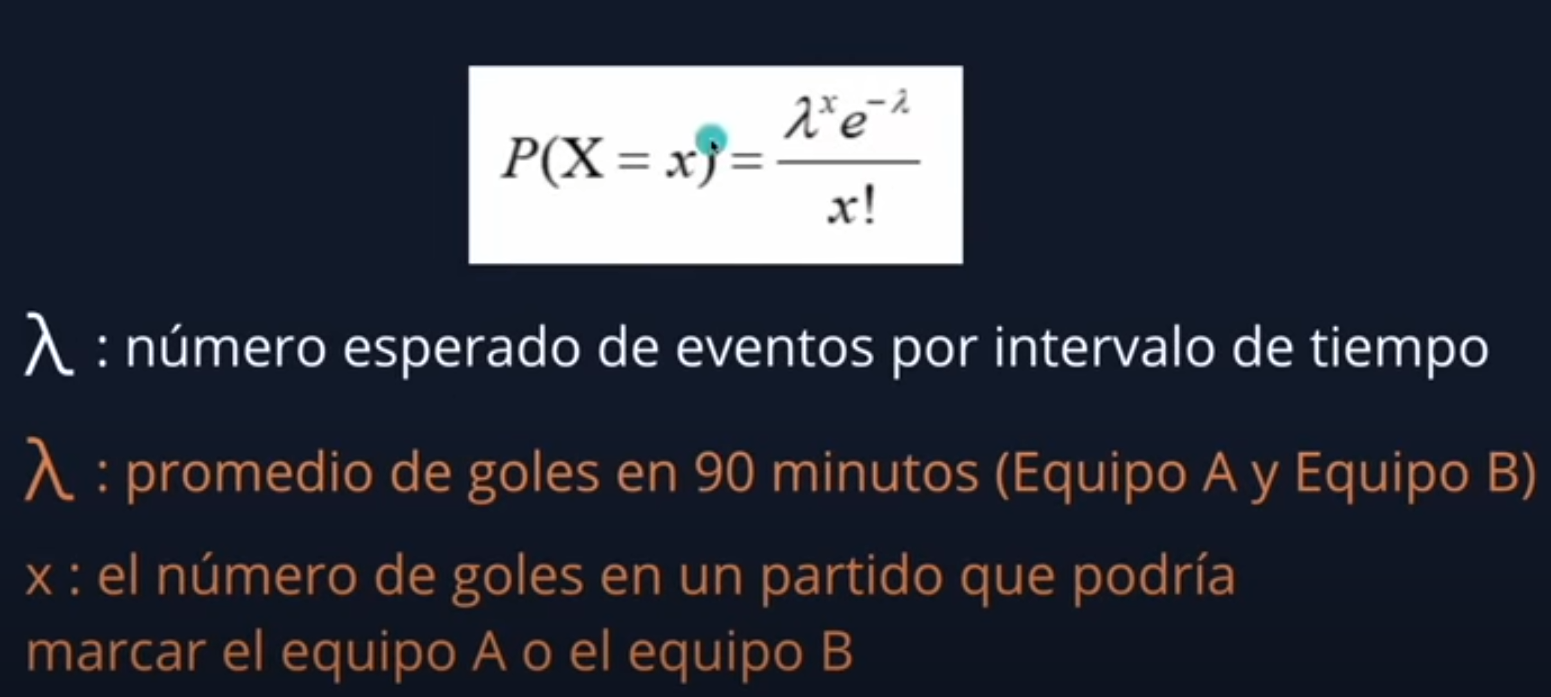

In [ ]:
def predict_points(home, away):
  if home in df_team_strength.index and away in df_team_strength.index:
    # GoalsFavor * GoalsAgainst
    lambda_home = df_team_strength.at[home, 'GoalsFavor'] * df_team_strength.at[away, 'GoalsAgainst']
    lambda_away = df_team_strength.at[away, 'GoalsFavor'] * df_team_strength.at[home, 'GoalsAgainst']
    prob_home, prob_away, prob_draw = 0, 0, 0
    # Number of goals HomeTeam (From zero to ten goals)
    for x in range(0, 11):
      # Number of goals AwayTeam (From zero to ten goals)
      for y in range(0, 11):
        p = poisson.pmf(x, lambda_home) * poisson.pmf(y, lambda_away)
        if x == y:
          prob_draw += p
        elif x > y:
          prob_home += p
        else:
          prob_away += p

    points_home = 3 * prob_home + prob_draw
    points_away = 3 * prob_away + prob_draw
    return (points_home, points_away)

  else:
    return (0, 0)


## **4.2 Probamos la funcion**


Recordamos que nuestra formula nos arrojara valores de 0 a 3, siendo estos los puntos que puede recibir al ganar, perder o empatar

In [ ]:
# Testeamos con partidos: Argentina - Mexico, England - USA, Qatar(H) - Ecuador
predict_points('Argentina', 'Mexico')

(2.339646284744194, 0.511922803351408)

Lo anterior quiere decir que de los 3 puntos posibles, Argentina estaria mas cercana a ganar (conseguir 3 puntos) contra Mexico (tenderia a conseguir 0 puntos)

In [ ]:
predict_points('England', 'United States')

(2.1550208345166393, 0.6486303505110735)

In [ ]:
predict_points('Qatar (H)', 'Ecuador')

(0, 0)

Estos valores son cero dado que no existe data historia de algun enfrentamiento entre estos dos. Esto no afectaria a los otros equipos del grupo como son Senegal y Paises Bajos, dado que estos si tienen data historica. Al contrario, afectaria mas a Qatar

# **5 Prediciendo el Mundial**

## **5.1 Fase de grupos**

Dividimos en grupo, octavos, cuartos, semifinal y final

In [ ]:
df_fixture_group_48 = df_fixture[:48].copy()
df_fixture_knockout = df_fixture[48:56].copy()
df_fixture_quarter = df_fixture[56:60].copy()
df_fixture_semifinal = df_fixture[60:62].copy()
df_fixture_final = df_fixture[62:].copy()

Corremos los partidos de la fase de grupo y actualizamos las tablas de cada grupo

In [ ]:
for group in dict_table:
  teams_in_group = dict_table[group]['Team'].values
  df_fixture_group_6 = df_fixture_group_48[df_fixture_group_48['home'].isin(teams_in_group)]
  for index, row in df_fixture_group_6.iterrows():
    home, away = row['home'], row['away']
    points_home, points_away = predict_points(home, away)
    dict_table[group].loc[dict_table[group]['Team'] == home, 'Pts'] += points_home
    dict_table[group].loc[dict_table[group]['Team'] == away, 'Pts'] += points_away

  dict_table[group] = dict_table[group].sort_values('Pts', ascending=False).reset_index()
  dict_table[group] = dict_table[group][['Team', 'Pts']]
  dict_table[group] = dict_table[group].round(0)

Mostramos las tablas de los Grupos actualizadas

In [ ]:
dict_table['Group A']

,Team,Pts
0,Netherlands,4.0
1,Senegal,2.0
2,Ecuador,2.0
3,Qatar (H),0.0


In [ ]:
dict_table['Group B']

,Team,Pts
0,England,6.0
1,Wales,5.0
2,United States,3.0
3,Iran,2.0


In [ ]:
dict_table['Group C']

,Team,Pts
0,Argentina,7.0
1,Poland,5.0
2,Mexico,4.0
3,Saudi Arabia,1.0


In [ ]:
dict_table['Group D']

,Team,Pts
0,France,7.0
1,Denmark,6.0
2,Tunisia,3.0
3,Australia,2.0


In [ ]:
dict_table['Group E']

,Team,Pts
0,Germany,7.0
1,Spain,5.0
2,Costa Rica,3.0
3,Japan,2.0


In [ ]:
dict_table['Group F']

,Team,Pts
0,Croatia,7.0
1,Belgium,5.0
2,Morocco,4.0
3,Canada,0.0


In [ ]:
dict_table['Group G']

,Team,Pts
0,Brazil,8.0
1,Switzerland,4.0
2,Serbia,3.0
3,Cameroon,2.0


In [ ]:
dict_table['Group H']

,Team,Pts
0,Portugal,6.0
1,Uruguay,5.0
2,Ghana,3.0
3,South Korea,2.0


## **5.2 Octavos de Final**

Actualizamos el fixture de octavos con el primer y segundo puesto de los grupos

In [ ]:
for group in dict_table:
  group_winner = dict_table[group].loc[0, 'Team']
  runners_up = dict_table[group].loc[1, 'Team']
  df_fixture_knockout.replace({f'Winners {group}': group_winner,
                               f'Runners-up {group}': runners_up}, inplace=True)
df_fixture_knockout['winner'] = '?'
df_fixture_knockout

,home,score,away,year,winner
48,Netherlands,Match 49,Wales,2022,?
49,Argentina,Match 50,Denmark,2022,?
50,France,Match 52,Poland,2022,?
51,England,Match 51,Senegal,2022,?
52,Germany,Match 53,Belgium,2022,?
53,Brazil,Match 54,Uruguay,2022,?
54,Croatia,Match 55,Spain,2022,?
55,Portugal,Match 56,Switzerland,2022,?


Creamos la funcion get_winner

In [ ]:
def get_winner(df_fixture_updated):
  for index, row in df_fixture_updated.iterrows():
    home, away = row['home'], row['away']
    points_home, points_away = predict_points(home, away)
    if points_home > points_away:
      winner = home
    else:
      winner = away
    df_fixture_updated.loc[index, 'winner'] = winner
  return df_fixture_updated

In [ ]:
get_winner(df_fixture_knockout)

,home,score,away,year,winner
48,Netherlands,Match 49,Wales,2022,Netherlands
49,Argentina,Match 50,Denmark,2022,Argentina
50,France,Match 52,Poland,2022,France
51,England,Match 51,Senegal,2022,England
52,Germany,Match 53,Belgium,2022,Germany
53,Brazil,Match 54,Uruguay,2022,Brazil
54,Croatia,Match 55,Spain,2022,Spain
55,Portugal,Match 56,Switzerland,2022,Portugal


## **5.3 Cuartos de final**

In [ ]:
def update_table(df_fixture_round_1, df_fixture_round_2):
  for index, row in df_fixture_round_1.iterrows():
    winner = df_fixture_round_1.loc[index, 'winner']
    partido = df_fixture_round_1.loc[index, 'score']
    df_fixture_round_2.replace({f'Winners {partido}': winner}, inplace=True)
    df_fixture_round_2['winner'] = '?'
  return df_fixture_round_2

In [ ]:
update_table(df_fixture_knockout, df_fixture_quarter)

,home,score,away,year,winner
56,Germany,Match 58,Brazil,2022,?
57,Netherlands,Match 57,Argentina,2022,?
58,Spain,Match 60,Portugal,2022,?
59,England,Match 59,France,2022,?


In [ ]:
get_winner(df_fixture_quarter)

,home,score,away,year,winner
56,Germany,Match 58,Brazil,2022,Brazil
57,Netherlands,Match 57,Argentina,2022,Netherlands
58,Spain,Match 60,Portugal,2022,Spain
59,England,Match 59,France,2022,France


## **5.4 Semifinal**

In [ ]:
update_table(df_fixture_quarter, df_fixture_semifinal)

,home,score,away,year,winner
60,Netherlands,Match 61,Brazil,2022,?
61,France,Match 62,Spain,2022,?


In [ ]:
get_winner(df_fixture_semifinal)

,home,score,away,year,winner
60,Netherlands,Match 61,Brazil,2022,Brazil
61,France,Match 62,Spain,2022,Spain


## **5.5 Final**

In [ ]:
update_table(df_fixture_semifinal, df_fixture_final)

,home,score,away,year,winner
62,Losers Match 61,Match 63,Losers Match 62,2022,?
63,Brazil,Match 64,Spain,2022,?


In [ ]:
get_winner(df_fixture_final)

,home,score,away,year,winner
62,Losers Match 61,Match 63,Losers Match 62,2022,Losers Match 62
63,Brazil,Match 64,Spain,2022,Brazil
